In [1]:
#   Imports
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import torch
import torch.nn as nn

In [2]:
#   Constants

#   Peak positons for E,A at 532. from 1-4, bulk layers 
omega_0_MoS2_L = np.array([[384.7,402.7],[382.5,404.9],[382.4,405.7],[382.4,406.7],[383,407.8]])

In [3]:
#   Methods and functions
def gauss(omega, fwhm, omega_0):
    return np.exp(-0.5*(((omega-omega_0)/fwhm)**2))/(fwhm*((2*np.pi)**0.5))

def raman_moment(spectra, intesnity, order):
    output = 0
    for i in range(698):
        output += (spectra[i]**order) * intesnity[i]
    return output

def varaince(first_moment, second_moment):
    return np.sqrt(np.abs(((first_moment)**2)-second_moment))

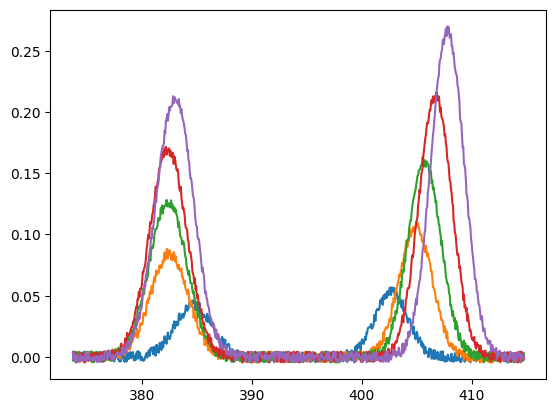

In [4]:
#   Testing sandbox
x = np.linspace(373.75,414.75,700)
y = np.zeros([5, 700])

for i in range(5):
    for j in range(700):
        y[i][j] = ((i+1)/5)*(0.9*gauss(x[j],1.7,omega_0_MoS2_L[i][0]) + gauss(x[j],1.5,omega_0_MoS2_L[i][1]))+(rand.randrange(-45,45)/10000)

for k in range(5):
    plt.plot(x,y[k])

In [5]:
#   Create 10000 samples with various layers and random noise as well as labels (layers)

samples = np.zeros([10000, 700])
layers = np.zeros(10000)
print(np.shape(samples))
for i in range(5):
    for j in range(2000*(i), 2000*(i+1)):
        layers[j] = i+1
        E_0 = omega_0_MoS2_L[i][0]
        A_0 = omega_0_MoS2_L[i][1]
        for k in range(700):
            samples[j][k] = ((i+1)/5)*(0.9*(gauss(x[k],1.7+(rand.randrange(-10,10)/75),omega_0_MoS2_L[i][0]+(rand.randrange(-10,10)/75)) + gauss(x[k],1.5+(rand.randrange(-10,10)/100),omega_0_MoS2_L[i][1]+(rand.randrange(-10,10)/100))))+(rand.randrange(-45,45)/10000)


(10000, 700)


In [7]:
#   Random sampling for test, train split

train_id = rand.sample(np.linspace(0,10000,10000).astype(np.int64).tolist(),7000)
# print(train_id)

train_spectra = np.zeros([7000,700])
train_label = np.zeros([7000])
test_spectra = np.zeros([3000,700])
test_label = np.zeros([3000])

train_index = 0
test_index = 0
for i in range(10000):
    # print(i)
    if i in train_id:
        train_spectra[train_index] = samples[i]
        train_label[train_index] = layers[i]
        train_index += 1
    else:
        test_spectra[test_index] = samples[i]
        test_label[test_index] = layers[i]
        test_index += 1

In [8]:
#   Raman fingerprinting
fingerprint = np.zeros([10000,2])

for i in range(10000):
    first_moment = raman_moment(x,samples[i],1)
    second_moment = raman_moment(x,samples[i],2)
    # print(first_moment)
    # print(second_moment)
    fingerprint[i][0] = second_moment/1e5
    fingerprint[i][1] = varaince(first_moment,second_moment)/1e3

In [165]:
#   Define simple model

####    THIS IS THE MODEL THAT ISN'T WORKING JACK
n_features = 1

class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(out_channels=64, in_channels=n_features, kernel_size = 3),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(kernel_size=10,stride=10))
        self.layer2 = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features=4416)
            )
        self.layer3 = nn.Sequential(
            nn.Linear(4416,100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,5),
            nn.Softmax(dim=1))
        
    def forward(self, x):
        out = x
        out = out.unsqueeze(1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return (out)
    
#   Test data labels
# trt_labels = np.zeros(7000)
# tet_labels = np.zeros(3000)

trt_labels = train_label-1
tet_labels = test_label-1

# for i in range(7000):
#     if train_label[i] == 2:
#         trt_labels[i] = 1
# for i in range(3000):
#     if test_label[i] == 2:
#         tet_labels[i] = 1

In [46]:
print(trt_labels)

[0. 0. 0. ... 4. 4. 4.]


In [166]:
#   Load model

model = ConvNet1D()
cirterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

total_step = len(train_spectra)

#   Intermediate step: convert to torch tensor
train_spectraT = (torch.from_numpy(train_spectra)).float()
test_spectraT = (torch.from_numpy(test_spectra)).float()
train_labelsT = torch.from_numpy(trt_labels).float()
test_labelsT = torch.from_numpy(tet_labels).float()
num_epochs = 50
batch_size = 64

#   print(np.shape(train_spectraT))

lost_list = []
acc_list = []

acc_list_epoch = []

In [ ]:
print(np.shape(train_spectraT))

torch.Size([7000, 700])


In [167]:
#   Training time, baby! Pray for me.

outputs_total = []
train_seg_total = []

for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))):
        train_spectraT_seg = train_spectraT[i*batch_size:(i+1)*batch_size]
        train_labelsT_seg = train_labelsT[i*batch_size:(i+1)*batch_size]

        # print(np.shape(train_spectraT_seg))
        # train_spectraT_seg = train_spectraT_seg.permute(1,0)
        #   Run the forward pass
        outputs = model(train_spectraT_seg)
        outputs_max = []
        for l in range(64):
            outputs_total.append([np.argmax(outputs.detach().numpy()[l])])
            train_seg_total.append(train_labelsT_seg.long()[l])
            outputs_max.append(np.argmax(outputs.detach().numpy()[l]))
            # print(np.argmax(outputs.detach().numpy()[l]))
        # np.append(outputs_total,outputs.detach().numpy())
        # print("outputs")
        # print(np.shape(outputs))
        # print(outputs)
        # print(np.shape(train_labelsT_seg.long()))
        # print(train_labelsT_seg.long())
        loss = cirterion(outputs, train_labelsT_seg.long())
        lost_list.append(loss.item())

        #   Backpropagation and Adam
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        #   Track accuracy
        # print("AAAAA: ", train_labelsT_seg.size(0))
        total = train_labelsT_seg.size(0)
        _, predicted = torch.max(outputs, 1)
        # _, actual = torch.max(train_labelsT_seg.long(), 0)
        # print("predicted, actual: ",predicted,", ",train_labelsT_seg.long())
        correct = (predicted == train_labelsT_seg.long()).sum().item()
        correct_sum = correct_sum + (correct/total)
        acc_list.append(correct / total)
    print("Epochs: ",epoch)
    print("Accuracy: ",correct_sum/int(np.floor(total_step/batch_size)))
    acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))



Epochs:  0
Accuracy:  0.17259174311926606
Epochs:  1
Accuracy:  0.17373853211009174
Epochs:  2
Accuracy:  0.23007454128440366
Epochs:  3
Accuracy:  0.275802752293578
Epochs:  4
Accuracy:  0.31966743119266056
Epochs:  5
Accuracy:  0.3696961009174312
Epochs:  6
Accuracy:  0.421875
Epochs:  7
Accuracy:  0.471473623853211
Epochs:  8
Accuracy:  0.5104644495412844
Epochs:  9
Accuracy:  0.5463016055045872
Epochs:  10
Accuracy:  0.5665137614678899
Epochs:  11
Accuracy:  0.596473623853211
Epochs:  12
Accuracy:  0.609375
Epochs:  13
Accuracy:  0.6238532110091743
Epochs:  14
Accuracy:  0.6400516055045872
Epochs:  15
Accuracy:  0.6466456422018348
Epochs:  16
Accuracy:  0.6614105504587156
Epochs:  17
Accuracy:  0.6723050458715596
Epochs:  18
Accuracy:  0.6809059633027523
Epochs:  19
Accuracy:  0.6892201834862385
Epochs:  20
Accuracy:  0.7032683486238532
Epochs:  21
Accuracy:  0.7170298165137615
Epochs:  22
Accuracy:  0.7226204128440367
Epochs:  23
Accuracy:  0.7307912844036697
Epochs:  24
Accuracy:

In [116]:
print(np.append([],[1,2]))

[1. 2.]


(348800, 1)
(348800,)


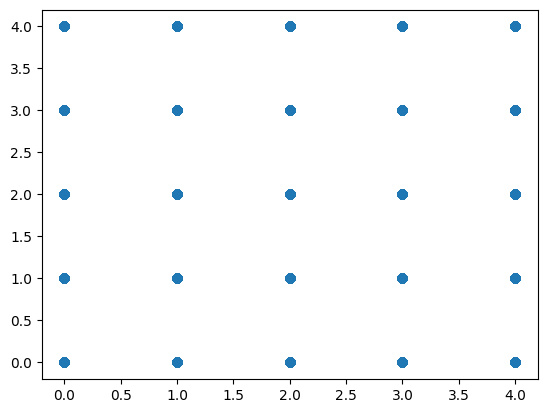

In [168]:
print(np.shape(outputs_total))
print(np.shape(train_seg_total))
plt.scatter(train_seg_total,outputs_total)

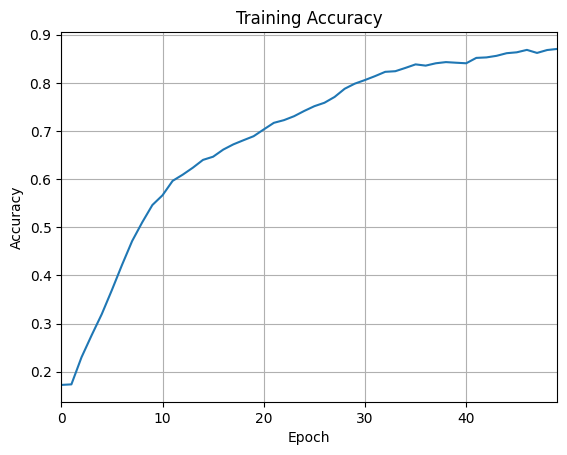

In [169]:
#   Plot the training accuracy
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(acc_list_epoch)
plt.show()
# print(correct_sum)

In [170]:
#   Test the model
model.eval()
with torch.no_grad():
    test_outputs = model(test_spectraT)
    _, predictedt = torch.max(test_outputs,1)
    total_t = test_labelsT.size(0)
    correct_t = (predictedt == test_labelsT.long()).sum().item()
    print("Test accuracy: ",(correct_t/total_t)*100)

Test accuracy:  41.766666666666666


In [176]:
#   Define conv2 model (two * layers)
n_features = 1

class ConvNet1D2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=n_features, out_channels=64,kernel_size=20),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=40),
            nn.Dropout(0.5),
            nn.MaxPool1d(kernel_size=10,stride=10))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(8192,100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,5),
            nn.Softmax(dim=1))
        
    def forward(self, x):
        out = x
        out = out.unsqueeze(1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [178]:
#   Load model

model = ConvNet1D2()
cirterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

total_step = len(train_spectra)

#   Intermediate step: convert to torch tensor
train_spectraT = (torch.from_numpy(train_spectra)).float()
test_spectraT = (torch.from_numpy(test_spectra)).float()
train_labelsT = torch.from_numpy(trt_labels).float()
test_labelsT = torch.from_numpy(tet_labels).float()
num_epochs = 50
batch_size = 64

#   print(np.shape(train_spectraT))

lost_list = []
acc_list = []

acc_list_epoch = []

In [179]:
#   Training time, baby! Pray for me.

for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))):
        train_spectraT_seg = train_spectraT[i*batch_size:(i+1)*batch_size]
        train_labelsT_seg = train_labelsT[i*batch_size:(i+1)*batch_size]

        # print(np.shape(train_spectraT_seg))
        # train_spectraT_seg = train_spectraT_seg.permute(1,0)
        #   Run the forward pass
        outputs = model(train_spectraT_seg)
        # print("outputs")
        # print(np.shape(outputs))
        # print(outputs)
        # print(np.shape(train_labelsT_seg.long()))
        # print(train_labelsT_seg.long())
        loss = cirterion(outputs, train_labelsT_seg.long())
        lost_list.append(loss.item())

        #   Backpropagation and Adam
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        #   Track accuracy
        # print("AAAAA: ", train_labelsT_seg.size(0))
        total = train_labelsT_seg.size(0)
        _, predicted = torch.max(outputs, 1)
        # _, actual = torch.max(train_labelsT_seg.long(), 0)
        # print("predicted, actual: ",predicted,", ",train_labelsT_seg.long())
        correct = (predicted == train_labelsT_seg.long()).sum().item()
        correct_sum = correct_sum + (correct/total)
        acc_list.append(correct / total)
    print("Epochs: ",epoch)
    print("Accuracy: ",correct_sum/int(np.floor(total_step/batch_size)))
    acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))



Epochs:  0
Accuracy:  0.16886467889908258
Epochs:  1
Accuracy:  0.14205848623853212
Epochs:  2
Accuracy:  0.21258600917431192
Epochs:  3
Accuracy:  0.32210435779816515
Epochs:  4
Accuracy:  0.40338302752293576
Epochs:  5
Accuracy:  0.4766341743119266
Epochs:  6
Accuracy:  0.5200688073394495
Epochs:  7
Accuracy:  0.5409977064220184
Epochs:  8
Accuracy:  0.5593463302752294
Epochs:  9
Accuracy:  0.5723910550458715
Epochs:  10
Accuracy:  0.583572247706422
Epochs:  11
Accuracy:  0.6083715596330275
Epochs:  12
Accuracy:  0.6145355504587156
Epochs:  13
Accuracy:  0.6294438073394495
Epochs:  14
Accuracy:  0.6374713302752294
Epochs:  15
Accuracy:  0.6371846330275229
Epochs:  16
Accuracy:  0.6275802752293578
Epochs:  17
Accuracy:  0.6475057339449541
Epochs:  18
Accuracy:  0.6549598623853211
Epochs:  19
Accuracy:  0.650802752293578
Epochs:  20
Accuracy:  0.6588302752293578
Epochs:  21
Accuracy:  0.6548165137614679
Epochs:  22
Accuracy:  0.6561066513761468
Epochs:  23
Accuracy:  0.6645642201834863

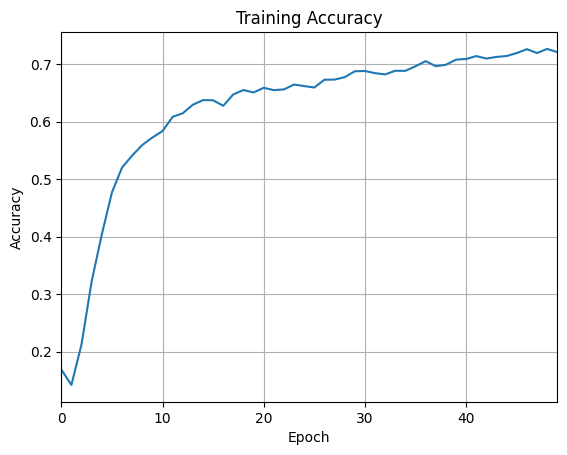

In [180]:
#   Plot the training accuracy
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(acc_list_epoch)
plt.show()
# print(correct_sum)

In [182]:
#   Test the model
model.eval()
with torch.no_grad():
    test_outputs = model(test_spectraT)
    _, predictedt = torch.max(test_outputs,1)
    total_t = test_labelsT.size(0)
    correct_t = (predictedt == test_labelsT.long()).sum().item()
    print("Test accuracy: ",(correct_t/total_t)*100)

Test accuracy:  19.733333333333334
